In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from cl.eval import EvalReader as EPPS
import seaborn as sns
import numpy as np
import os


In [11]:
printn = print
def print1(*arg, **karg):
    pass

def common_parse(name, add):
    if name.find("pertask")>=0:
        _, tid, fold = name.split("_")
        name = "{} on fold {}".format(tid, fold)
    return "Result of Task {} {}:".format(name, add)
def listdct_to_dct(lst, kname, vname):
    ret = {}
    for d in lst:
        ret[tuple(d[kname])] = d[vname]
    return ret
def parse_pairwise_ic(name, measure):
    tname = common_parse(name, "Pairwise Inconsistency")
    print(tname)
    pairwise = listdct_to_dct(measure["inconsist_pairwise"], kname="compare", vname="consistency")
    idx = measure["index"]
    l = len(idx)
    _idx_name = ["Model {}".format(i) for i in idx]
    _df = pd.DataFrame(index = _idx_name[:-1], columns = _idx_name[1:]).fillna("")
    for i in range(l):
        for j in range(i+1, l):
            _df.loc[_idx_name[i], _idx_name[j]] = pairwise[(idx[i],idx[j])]
    #_df.style.set_caption(tname)
    print(_df)
    return _df

def parse_acc(name, measure):
    print(common_parse(name, "Accuracy Per Step"))
    for i in range(len(measure["index"])):
        print(measure["acc_list"][i], end="\t")
    print("avg acc", np.mean(measure["acc_list"]))
    return np.mean(measure["acc_list"])#measure["acc_list"][0]#np.mean(measure["acc_list"])#measure["acc_list"][-1]#

def parse_total(name, measure):
    print(common_parse(name, "Inconsistency Together"))
    print(measure["inconsist_tot"])
    return measure["inconsist_tot"]

def filter_lst(lst, s):
    rst = []
    for _s in lst:
        if s[0] == "-":
            if _s.find(s)==-1:
                rst.append(_s)
        else:
            if _s.find(s)>=0:
                rst.append(_s)
    return rst

def sname(lst):
    global common_filter
    lst += common_filter
    dn = os.listdir("results")
    for s in lst:
        dn = filter_lst(dn, s)
    if len(dn) > 1:
        print("multiple result" + str(dn))
    mx_sz = 1000
    mx_id = 0
    for idx, _d in enumerate(dn):
        if len(_d) < mx_sz:
            mx_sz = len(_d)
            mx_id = idx
    printn(dn[mx_id])
    return os.path.join("results", dn[mx_id], "Seed0")

In [12]:
def read_result(evaluator, bname):
    global rec
    e = evaluator
    print("="*50)
    rec[bname] = []
    print(bname)
    for name in e.names:
        parse_pairwise_ic(name, e._measure_pairwise(name))
        print()
        acc = parse_acc(name,e._measure_acc(name))
        print()
        tot = parse_total(name, e._measure([name]))
        true_name = "_".join(name.split("_")[-2:])
        rec[bname].append((true_name,tot,acc))
        print(tot)
def draw_pic(picname, names):
    
    #names = [ ]#, "lwf_scratch", "ewc_scratch", "vanilla_scratch",]
    tasks = []
    vals = []
    comps = []
    accs = []
    print(rec)
    for keyword in ["train", "test", "val"]:
        for name in names:
            for v in rec[name]:
                task, val, acc = v
                if task.find(keyword)<0:
                    continue
                comps.append(name)
                tasks.append(task)
                accs.append(acc)
                vals.append(val)
    plt.figure(figsize=(25,10))
    plt.subplot(1,2,1)
    df = pd.DataFrame({"Task":tasks, "Method":comps, "Inconsistency":vals, "Acc":accs})
    pd.melt(df, id_vars=['Task'], value_vars=['Inconsistency'])
    sns.barplot(x = 'Task', y = 'Inconsistency', data = df, hue="Method")
    plt.ylabel('Inconsistency')
    plt.title('Inconsistency over different baselins')
    #plt.savefig("Inconsistency_{}.png".format(picname))
    #plt.show()
    #plt.figure(figsize=(10,10))
    plt.subplot(1,2,2)
    df = pd.DataFrame({"Task":tasks, "Method":comps, "Inconsistency":vals, "Acc":accs})
    pd.melt(df, id_vars=['Task'], value_vars=['Acc'])
    sns.barplot(x = 'Task', y = 'Acc', data = df, hue="Method")
    plt.ylabel('Acc')
    plt.title('Acc over different baselins')
    plt.savefig("Acc_{}.png".format(picname))
    plt.show()

multiple result['cifar10_ResNet18_1.0e-03_#scratch_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgS40_DomS5_FixInit', 'cifar10_small#Aug_CF_ResNet18_1.0e-03_#scratch_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgS40_DomS5_FixInit', 'cifar10_small_ResNet18_1.0e-03_#scratch_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgS40_DomS5_FixInit', 'cifar10#Aug_CF_ResNet18_1.0e-03_#scratch_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgS40_DomS5_FixInit']
cifar10_ResNet18_1.0e-03_#scratch_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgS40_DomS5_FixInit
sequential
vanilla_scratch
Result of Task perslice__Task_0_test Pairwise Inconsistency:
          Model 1   Model 2   Model 3   Model 4
Model 0  0.075042  0.058179  0.046374  0.042159
Model 1            0.055649  0.047639  0.044688
Model 2                      0.053963  0.047218
Model 3                                0.054806

Result of Task perslice__Task_0_test Accuracy Per Step:
0.7390387858347386	0.7820404721753794	0.8263069139966274	0.8435919055649241	

Result of Task perslice__Task_0_train Pairwise Inconsistency:
        Model 1 Model 2 Model 3 Model 4
Model 0     0.0     0.0     0.0     0.0
Model 1             0.0     0.0     0.0
Model 2                     0.0     0.0
Model 3                             0.0

Result of Task perslice__Task_0_train Accuracy Per Step:
1.0	1.0	1.0	1.0	1.0	avg acc 1.0

Result of Task perslice__Task_0_train Inconsistency Together:
0.0
0.0
Result of Task perslice__Task_1_test Pairwise Inconsistency:
          Model 2   Model 3   Model 4
Model 1  0.076214  0.058626  0.051926
Model 2            0.054439  0.049832
Model 3                       0.05402

Result of Task perslice__Task_1_test Accuracy Per Step:
0.7604690117252931	0.7801507537688442	0.8195142378559463	0.8333333333333334	avg acc 0.7983668341708543

Result of Task perslice__Task_1_test Inconsistency Together:
0.16519823788546256
0.16519823788546256
Result of Task perslice__Task_1_val Pairwise Inconsistency:
          Model 2   Model 3   Model 4
Mode

Result of Task perslice__Task_1_train Pairwise Inconsistency:
         Model 2  Model 3  Model 4
Model 1  0.00012  0.00012  0.00012
Model 2           0.00012  0.00012
Model 3                    0.00012

Result of Task perslice__Task_1_train Accuracy Per Step:
0.9997608227696724	0.9998804113848362	0.9998804113848362	0.9998804113848362	avg acc 0.9998505142310452

Result of Task perslice__Task_1_train Inconsistency Together:
0.0003588516746411483
0.0003588516746411483
Result of Task perslice__Task_2_test Pairwise Inconsistency:
          Model 3   Model 4
Model 2  0.025974   0.02346
Model 3            0.025555

Result of Task perslice__Task_2_test Accuracy Per Step:
0.9120234604105572	0.9208211143695014	0.9325513196480938	avg acc 0.9217986314760508

Result of Task perslice__Task_2_test Inconsistency Together:
0.04777216352779054
0.04777216352779054
Result of Task perslice__Task_2_val Pairwise Inconsistency:
          Model 3   Model 4
Model 2  0.022632  0.026823
Model 3            0.03269

Result of Task perslice__Task_0_train Pairwise Inconsistency:
        Model 1 Model 2   Model 3 Model 4
Model 0     0.0     0.0  0.001425     0.0
Model 1             0.0  0.001425     0.0
Model 2                  0.001425     0.0
Model 3                               0.0

Result of Task perslice__Task_0_train Accuracy Per Step:
1.0	1.0	1.0	0.9985754985754985	1.0	avg acc 0.9997150997150996

Result of Task perslice__Task_0_train Inconsistency Together:
0.0014245014245014246
0.0014245014245014246
Result of Task perslice__Task_1_test Pairwise Inconsistency:
          Model 2   Model 3   Model 4
Model 1  0.082324  0.094431  0.072639
Model 2            0.082324  0.062954
Model 3                      0.077482

Result of Task perslice__Task_1_test Accuracy Per Step:
0.5665859564164649	0.6029055690072639	0.6295399515738499	0.6585956416464891	avg acc 0.6144067796610169

Result of Task perslice__Task_1_test Inconsistency Together:
0.2606837606837607
0.2606837606837607
Result of Task perslice__Tas

Result of Task perslice__Task_2_test Inconsistency Together:
0.07813319349764027
0.07813319349764027
Result of Task perslice__Task_2_val Pairwise Inconsistency:
          Model 3   Model 4
Model 2  0.038558  0.046102
Model 3            0.053646

Result of Task perslice__Task_2_val Accuracy Per Step:
0.7912824811399832	0.8248113998323554	0.8298407376362112	avg acc 0.8153115395361833

Result of Task perslice__Task_2_val Inconsistency Together:
0.08686440677966102
0.08686440677966102
Result of Task perslice__Task_2_train Pairwise Inconsistency:
        Model 3 Model 4
Model 2     0.0     0.0
Model 3             0.0

Result of Task perslice__Task_2_train Accuracy Per Step:
0.999880354151711	1.0	1.0	avg acc 0.9999601180505703

Result of Task perslice__Task_2_train Inconsistency Together:
0.0
0.0
Result of Task perslice__Task_3_test Pairwise Inconsistency:
         Model 4
Model 3  0.03044

Result of Task perslice__Task_3_test Accuracy Per Step:
0.8243521184697655	0.8543809132044426	avg acc 

Result of Task perslice__Task_0_test Pairwise Inconsistency:
         Model 1   Model 2   Model 3   Model 4
Model 0  0.06113  0.050169  0.040894  0.049325
Model 1           0.043423  0.044266  0.048061
Model 2                     0.045953  0.051855
Model 3                               0.039629

Result of Task perslice__Task_0_test Accuracy Per Step:
0.7158516020236088	0.7660202360876898	0.7963743676222597	0.8279932546374368	0.8161888701517707	avg acc 0.7844856661045532

Result of Task perslice__Task_0_test Inconsistency Together:
0.1519434628975265
0.1519434628975265
Result of Task perslice__Task_0_val Pairwise Inconsistency:
          Model 1   Model 2   Model 3   Model 4
Model 0  0.059022  0.049747   0.05312  0.053963
Model 1            0.045531  0.048904  0.049747
Model 2                      0.043845  0.048061
Model 3                                0.037943

Result of Task perslice__Task_0_val Accuracy Per Step:
0.7352445193929174	0.7841483979763912	0.8111298482293423	0.8220910623

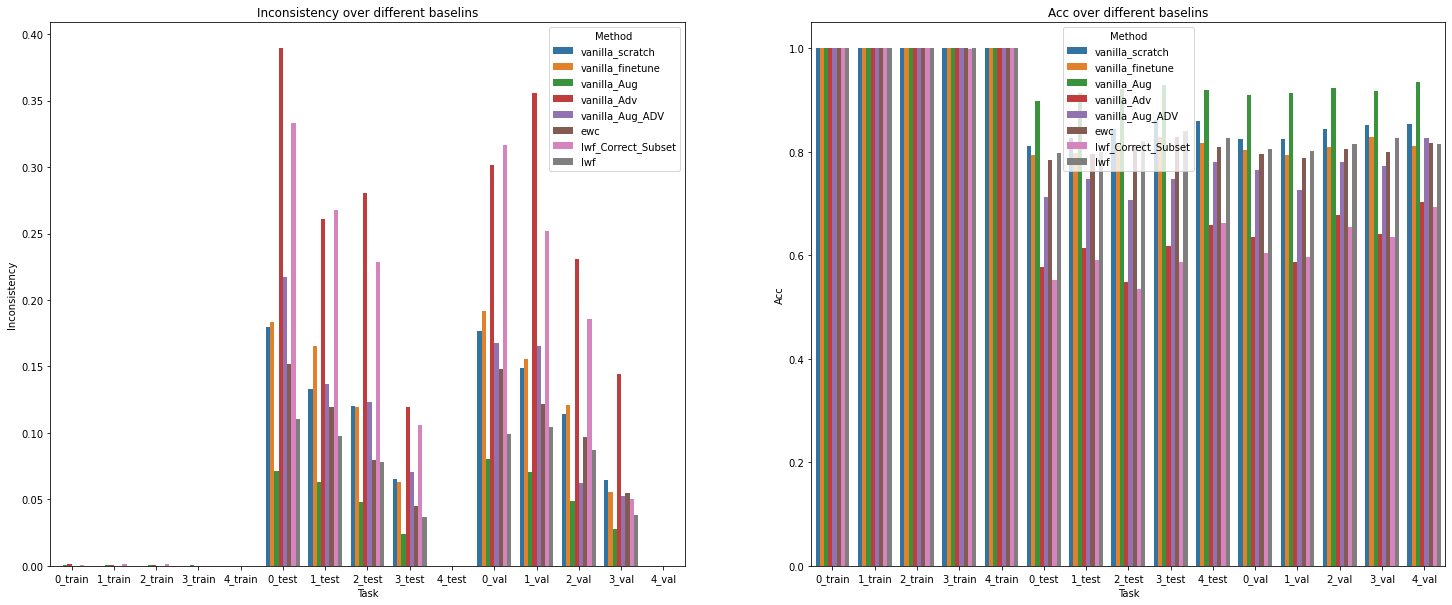

In [14]:
epps = EPPS()
case = 2
if case  == 1:
    common_filter = ["cifar10", "small", "ResNet18_1.0e-03","CTdata", "FixInit"]#"CvgS200"]"small",
    for i in range(1):
        rec = {}
        epps.load(sname(["scratch"]))#, "small_"]
        epps.set_order("sequential")
        read_result(epps, "vanilla_scratch")
        
        epps.load(sname(["vanilla"]))#, "small_"]
        epps.set_order("sequential")
        read_result(epps, "vanilla_finetune")
        
        epps.load(sname(["#Aug_CF_R"]))
        epps.set_order("sequential")
        read_result(epps, "vanilla_Aug")

        epps.load(sname(["#Aug_CF_ADV_R"]))
        epps.set_order("sequential")
        read_result(epps, "vanilla_Aug_ADV")

        epps.load(sname(["#Aug_ADV"]))
        epps.set_order("sequential")
        read_result(epps, "vanilla_Adv")
        
        #epps.load(sname(["scratch"]))
        #epps.set_order("sequential")
        #read_result(epps, "vanilla_scratch")
        
        epps.load(sname(["#lwf1.00e+00_DS"]))
        epps.set_order("sequential")
        read_result(epps, "lwf")

        epps.load(sname(["#lwf1.00e+00_unsup"]))
        epps.set_order("sequential")
        read_result(epps, "lwf_Unsupervised_SameDist")

        epps.load(sname(["#lwf1.00e+00#corrset"]))
        epps.set_order("sequential")
        read_result(epps, "lwf_Correct_Subset")  

        epps.load(sname(["#ewc"]))
        epps.set_order("sequential")
        read_result(epps,"ewc")
        draw_pic("Data_Inc_seed_{}".format(i),\
                 names=[ "vanilla_scratch", "vanilla_finetune", "vanilla_Aug", "vanilla_Adv", "vanilla_Aug_ADV", "ewc", "lwf", "lwf_Unsupervised_SameDist", "lwf_Correct_Subset"])   
elif case == 2:
    common_filter = ["cifar10", "ResNet18_1.0e-03","CTdata", "FixInit", "-small"]#"CvgS200"]"small",
    for i in range(1):
        rec = {}
        epps.load(sname(["scratch"]))#, "small_"]
        epps.set_order("sequential")
        read_result(epps, "vanilla_scratch")
        
        epps.load(sname(["vanilla"]))#, "small_"]
        epps.set_order("sequential")
        read_result(epps, "vanilla_finetune")
        
        epps.load(sname(["#Aug_CF_R"]))
        epps.set_order("sequential")
        read_result(epps, "vanilla_Aug")

        epps.load(sname(["#Aug_CF_ADV_R"]))
        epps.set_order("sequential")
        read_result(epps, "vanilla_Aug_ADV")

        epps.load(sname(["#Aug_ADV"]))
        epps.set_order("sequential")
        read_result(epps, "vanilla_Adv")
        
        #epps.load(sname(["scratch"]))
        #epps.set_order("sequential")
        #read_result(epps, "vanilla_scratch")
        
        epps.load(sname(["#lwf1.00e+00_DS"]))
        epps.set_order("sequential")
        read_result(epps, "lwf")

        #epps.load(sname(["#lwf1.00e+00_unsup"]))
        #epps.set_order("sequential")
        #read_result(epps, "lwf_Unsupervised_SameDist")

        epps.load(sname(["#lwf1.00e+00#corrset"]))
        epps.set_order("sequential")
        read_result(epps, "lwf_Correct_Subset")  

        epps.load(sname(["#ewc"]))
        epps.set_order("sequential")
        read_result(epps,"ewc")
        draw_pic("Data_Inc_seed_{}".format(i),\
                 names=[ "vanilla_scratch", "vanilla_finetune", "vanilla_Aug", "vanilla_Adv", "vanilla_Aug_ADV", "ewc","lwf_Correct_Subset", "lwf",])# "lwf_Unsupervised_SameDist", "lwf_Correct_Subset"])      
elif case ==3:
    for i in range(1):
        rec = {}
        #epps.load("results/cifar10_5_domain_inc")
        epps.load("results/cifar10_ResNet18_1.0e-02_#vanilla_DScifar10_CIMmask_CTdomain_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
        read_result(epps, "vanilla_finetune")
        epps.load("results/cifar10_ResNet18_1.0e-02_#lwf1.00e+00_DScifar10_CIMmask_CTdomain_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
        read_result(epps, "lwf")
        epps.load("results/cifar10_ResNet18_1.0e-02_#ewc5.00e+03_DScifar10_CIMmask_CTdomain_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
        read_result(epps,"ewc")
        epps.load("results/cifar10_ResNet18_1.0e-02_#scratch_DScifar10_CIMmask_CTdomain_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
        read_result(epps, "vanilla_scratch")
        """epps.load("results/cifar10_ResNet18_1.0e-02_#lwf1.00e+00#scratch_DScifar10_CIMmask_CTdomain_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
        read_result(epps, "lwf_scratch")
        epps.load("results/cifar10_ResNet18_1.0e-02_#ewc5.00e+03#scratch_DScifar10_CIMmask_CTdomain_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
        read_result(epps,"ewc_scratch")"""
        draw_pic("Domain_Inc_seed_{}".format(i),\
                 names=["vanilla_scratch", "vanilla_finetune", "ewc", "lwf"]) 
elif case == 4:
    for i in range(1):
        rec = {}
        #epps.load("results/cifar10_5_domain_inc")
        epps.load("results/cifar10_ResNet18_1.0e-02_#vanilla_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
        epps.set_order("sequential")
        read_result(epps, "vanilla_finetune")
        epps.load("results/cifar10_ResNet18_1.0e-02_#lwf1.00e+00_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
        epps.set_order("sequential")
        read_result(epps, "lwf")
        epps.load("results/cifar10_ResNet18_1.0e-02_#scratch_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
        epps.set_order("sequential")
        read_result(epps, "vanilla_scratch")
        epps.load("results/cifar10_ResNet18_1.0e-02_#ewc5.00e+03_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
        epps.set_order("sequential")
        read_result(epps,"ewc")
        """epps.load("results/cifar10_ResNet18_1.0e-02_#lwf1.00e+00#scratch_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
        read_result(epps, "lwf_scratch")
        epps.load("results/cifar10_ResNet18_1.0e-02_#ewc5.00e+03#scratch_DScifar10_CIMmask_CTdata_inc_DAsequential_CvgD9.00e-01_CvgT1.000000e-03_DomS5/Seed{}".format(i))
        read_result(epps,"ewc_scratch")"""
        draw_pic("Data_Inc_seed_{}".format(i),\
                 names=["vanilla_scratch", "vanilla_finetune", "ewc", "lwf"]) 

In [ ]:
from cl.utils import get_fixed_random_generator
import itertools
print(list(itertools.islice(get_fixed_random_generator(10,1), 5)))

In [ ]:
print(epps.names)
print(epps.hist_version["pertask_0_test"][:10,:10])